# Introduction
This notebook compares four time-series models performance to predict total daily energy demand in Saskatchewan. These models utilized include Fb Prophet, LightGBM (Light Gradient Boosting Machine), SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors), LSTM (Long Short-Term Memory), Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM. 

Each model is trained and tested using a train-test split and cross-validation. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and potential improvements for future work are considered.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [5]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [3]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

Mean Squared Error: 6656.06
Mean Absolute Error: 70.18
Root Mean Squared Error: 81.58
R-squared: 0.85
Mean Absolute Percentage Error: 7.33%
Median Absolute Percentage Error: 7.05%


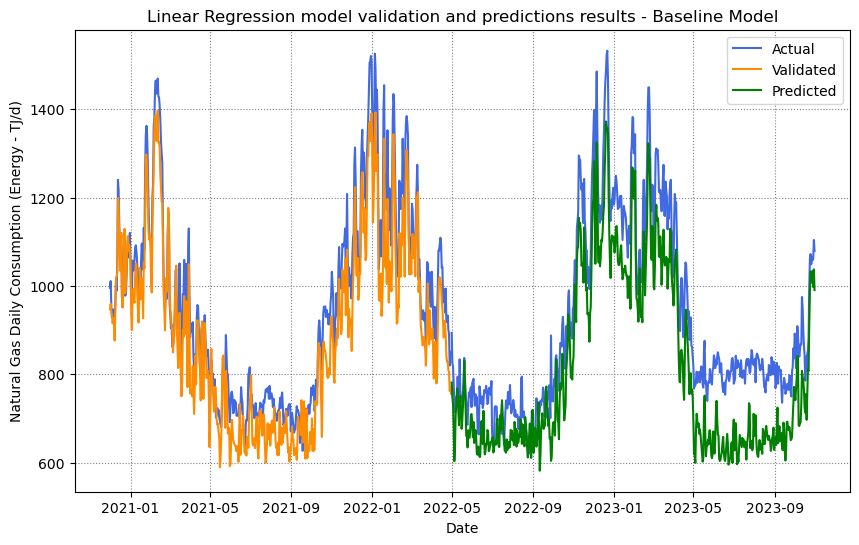

Mean Squared Error: 14196.40
Mean Absolute Error: 107.34
Root Mean Squared Error: 119.15
R-squared: 0.66
Mean Absolute Percentage Error: 11.96%
Median Absolute Percentage Error: 11.04%


In [37]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()
training_df = learning_df[learning_df['DATE'] < '2020-12-01']
validation_df = learning_df[learning_df['DATE'] >= '2020-12-01']

# Function to calculate MAPE and MdAPE
def calculate_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mape, mdape

# Use the train_df for training
X_train = training_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_train = training_df['NG_DEMAND']

# Use the validation_df for testing
X_validate = validation_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_validate = validation_df['NG_DEMAND']

# Use the validation_df for testing
X_test = testing_data_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_test = testing_data_df['NG_DEMAND']

# Create a Linear Regression object
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
validations = lr.predict(X_validate)

# Make predictions on the test set
predictions = lr.predict(X_test)

# Calculate the mean squared error of the validations
mse_bm = mean_squared_error(y_validate, validations)
mae_bm = mean_absolute_error(y_validate, validations)
rmse_bm = np.sqrt(mse_bm)
r2_bm = r2_score(y_validate, validations)
mape_bm, mdape_bm = calculate_percentage_error(y_validate, validations)

# Calculate the mean squared error of the predictions
test_mse_bm = mean_squared_error(y_test, predictions)
test_mae_bm = mean_absolute_error(y_test, predictions)
test_rmse_bm = np.sqrt(test_mse_bm)
test_r2_bm = r2_score(y_test, predictions)
test_mape_bm, test_mdape_bm = calculate_percentage_error(y_test, predictions)

# Convert the Date to datetime
validation_df['DATE'] = pd.to_datetime(validation_df['DATE'])
testing_data_df['DATE'] = pd.to_datetime(testing_data_df['DATE'])

# Print the validations performance metrics
print(f'Mean Squared Error: {mse_bm:.2f}')
print(f'Mean Absolute Error: {mae_bm:.2f}')
print(f'Root Mean Squared Error: {rmse_bm:.2f}')
print(f'R-squared: {r2_bm:.2f}')
print(f'Mean Absolute Percentage Error: {mape_bm:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_bm:.2f}%')

# Plot actual vs. forecast values
plt.figure(figsize=(10, 6))
plt.plot(validation_df['DATE'], y_validate, label='Actual', color='royalblue')
plt.plot(validation_df['DATE'], validations, label='Validated', color='darkorange')
plt.plot(testing_data_df['DATE'], y_test, color='royalblue')
plt.plot(testing_data_df['DATE'], predictions, label='Predicted', color='green')
plt.title('Linear Regression model validation and predictions results - Baseline Model')
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Consumption (Energy - TJ/d)')
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

# Create a dataframe that contains testing_set_df['DATE'], testing_set_df['NG_DEMAND'], and y_pred
baseline_results_df = testing_data_df[['DATE', 'NG_DEMAND']].copy()
baseline_results_df['Predicted_NG_DEMAND'] = predictions

# Print the predictions performance metrics
print(f'Mean Squared Error: {test_mse_bm:.2f}')
print(f'Mean Absolute Error: {test_mae_bm:.2f}')
print(f'Root Mean Squared Error: {test_rmse_bm:.2f}')
print(f'R-squared: {test_r2_bm:.2f}')
print(f'Mean Absolute Percentage Error: {test_mape_bm:.2f}%')
print(f'Median Absolute Percentage Error: {test_mdape_bm:.2f}%')

In [38]:
baseline_results_df.to_csv('../data/baseline_prediction.csv', index=False)
(baseline_results_df)

,DATE,NG_DEMAND,Predicted_NG_DEMAND
3103,2022-05-01,894,781.657240
3104,2022-05-02,826,748.991212
3105,2022-05-03,818,733.653709
3106,2022-05-04,782,679.871677
3107,2022-05-05,737,603.493364
...,...,...,...
3647,2023-10-27,1066,1007.483542
3648,2023-10-28,1058,1034.171223
3649,2023-10-29,1062,997.379792
3650,2023-10-30,1104,1037.494016


In [39]:
baseline_predictions_df = pd.read_csv('../data/baseline_prediction.csv')
baseline_predictions_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-01,894,781.657240
1,2022-05-02,826,748.991212
2,2022-05-03,818,733.653709
3,2022-05-04,782,679.871677
4,2022-05-05,737,603.493364


In [8]:
# Define the metrics for the predicted model
baseline_prediction_metrics = [test_mse_bm, test_rmse_bm, test_mape_bm, test_mae_bm, test_mdape_bm, test_r2_bm]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_baseline_pred = pd.DataFrame({'Baseline Model Prediction': baseline_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_baseline_pred = df_baseline_pred.transpose()

# Save the DataFrame to a CSV file
df_baseline_pred.to_csv('../data/baseline_predictions_metrics.csv', index=False)
df_baseline_pred.head()

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model Prediction,14196.398881,119.148642,11.963864,107.343951,11.039235,0.662633


# Model Evaluations

## 1. Performance Metrics

In [9]:
# Read the CSV file
baseline_predictions_metrics_df = pd.read_csv('../data/baseline_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
baseline_predictions_metrics_df.insert(0, 'Model', 'Baseline')
baseline_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,Baseline,14196.398881,119.148642,11.963864,107.343951,11.039235,0.662633


**Prophet Model**

In [10]:
# Read the CSV file
prophet_predictions_metrics_df = pd.read_csv('../data/prophet_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
prophet_predictions_metrics_df.insert(0, 'Model', 'Prophet')
prophet_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,Prophet,4337.651102,65.860847,NaN,53.100838,NaN,0.896919


In [41]:
prophet_predictions_df = pd.read_csv('../data/prophet_prediction.csv')
prophet_predictions_df.head()


,ds,y,yhat
0,2022-05-01,894,843.235901
1,2022-05-02,826,822.467927
2,2022-05-03,818,795.454454
3,2022-05-04,782,759.290193
4,2022-05-05,737,696.449118


In [42]:
prophet_predictions_df = prophet_predictions_df.rename(columns={'ds': 'DATE', 'y': 'NG_DEMAND', 'yhat': 'Predicted_NG_DEMAND'})
print(prophet_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND
0    2022-05-01        894           843.235901
1    2022-05-02        826           822.467927
2    2022-05-03        818           795.454454
3    2022-05-04        782           759.290193
4    2022-05-05        737           696.449118
..          ...        ...                  ...
544  2023-10-27       1066          1199.852283
545  2023-10-28       1058          1221.488383
546  2023-10-29       1062          1189.455045
547  2023-10-30       1104          1248.153253
548  2023-10-31       1079          1194.691063

[549 rows x 3 columns]


**LSTM Model**

In [13]:
# Read the CSV file
lstm_predictions_metrics_df = pd.read_csv('../data/lstm_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
lstm_predictions_metrics_df.insert(0, 'Model', 'LSTM')
lstm_predictions_metrics_df.head()

,Model,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
0,LSTM,1883.36387,31.632225,43.39774,3.429946,2.74334,0.955351


In [43]:
lstm_predictions_df = pd.read_csv('../data/lstm_prediction.csv')
print(lstm_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND
0    2022-05-03      826.0            893.61597
1    2022-05-04      818.0            831.37756
2    2022-05-05      782.0            821.90250
3    2022-05-06      737.0            791.35140
4    2022-05-07      714.0            748.77330
..          ...        ...                  ...
542  2023-10-27     1049.0           1074.37130
543  2023-10-28     1066.0           1048.98850
544  2023-10-29     1058.0           1078.61020
545  2023-10-30     1062.0           1074.39780
546  2023-10-31     1104.0           1071.35520

[547 rows x 3 columns]


**LightGBM Model**

In [15]:
# Read the CSV file
lightgbm_predictions_metrics_df = pd.read_csv('../data/lightgbm_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
lightgbm_predictions_metrics_df.insert(0, 'Model', 'LightGBM')
lightgbm_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,LightGBM,14303.781849,119.598419,12.20373,108.724888,11.47436,0.660082


In [44]:
lightgbm_predictions_df = pd.read_csv('../data/lightgbm_prediction.csv')
lightgbm_predictions_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-01,894,743.539982
1,2022-05-02,826,714.426287
2,2022-05-03,818,706.489290
3,2022-05-04,782,652.244757
4,2022-05-05,737,659.875452


**SARIMAX Model**

In [17]:
# Read the CSV file
sarimax_predictions_metrics_df = pd.read_csv('../data/sarimax_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
sarimax_predictions_metrics_df.insert(0, 'Model', 'SARIMAX')
sarimax_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,SARIMAX,4410.0,66.4,6.17,54.8,5.15,0.895


In [45]:
sarimax_predictions_df = pd.read_csv('../data/sarimax_prediction.csv')
print(sarimax_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND
0    2022-05-01        894           898.334447
1    2022-05-02        826           844.009205
2    2022-05-03        818           826.412084
3    2022-05-04        782           844.158550
4    2022-05-05        737           752.060869
..          ...        ...                  ...
544  2023-10-27       1066          1072.562150
545  2023-10-28       1058          1079.408825
546  2023-10-29       1062          1068.147420
547  2023-10-30       1104          1105.819448
548  2023-10-31       1079          1059.290310

[549 rows x 3 columns]


**Hybrid LSTM-Prophet**

In [19]:
# Read the CSV file
hybrid_predictions_metrics_df = pd.read_csv('../data/hybrid_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
hybrid_predictions_metrics_df.insert(0, 'Model', 'LSTM-Prophet')
hybrid_predictions_metrics_df.head()

,Model,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
0,LSTM-Prophet,2638.454094,44.810526,51.365885,5.074441,4.367038,0.937336


In [46]:
hybrid_predictions_df = pd.read_csv('../data/hybrid_prediction.csv')
hybrid_predictions_df.head()

,ds,y,Predicted_y,Optimized_Predicted_y
0,2022-05-01,894,820.883303,841.266054
1,2022-05-02,826,772.038173,789.767253
2,2022-05-03,818,754.096731,773.140112
3,2022-05-04,782,715.880441,735.235040
4,2022-05-05,737,660.534089,681.433595


In [47]:
hybrid_predictions_df = hybrid_predictions_df.rename(columns={'ds': 'DATE', 'y': 'NG_DEMAND', 'Predicted_y': 'Predicted_NG_DEMAND'})
print(hybrid_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND  Optimized_Predicted_y
0    2022-05-01        894           820.883303             841.266054
1    2022-05-02        826           772.038173             789.767253
2    2022-05-03        818           754.096731             773.140112
3    2022-05-04        782           715.880441             735.235040
4    2022-05-05        737           660.534089             681.433595
..          ...        ...                  ...                    ...
543  2023-10-26       1049          1009.214576            1025.248450
544  2023-10-27       1066          1011.565990            1029.354671
545  2023-10-28       1058          1017.184168            1033.337549
546  2023-10-29       1062          1004.188435            1022.411228
547  2023-10-30       1104          1052.492601            1069.916033

[548 rows x 4 columns]


In [22]:
# Append the DataFrames
models_evaluation_df = pd.concat([baseline_predictions_metrics_df, prophet_predictions_metrics_df, lstm_predictions_metrics_df, hybrid_predictions_metrics_df, 
                                  sarimax_predictions_metrics_df, lightgbm_predictions_metrics_df], ignore_index=True)

models_evaluation_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,Baseline,14196.398881,119.148642,11.963864,107.343951,11.039235,0.662633
1,Prophet,4337.651102,65.860847,NaN,53.100838,NaN,0.896919
2,LSTM,1883.363870,43.397740,3.429946,31.632225,2.743340,0.955351
3,LSTM-Prophet,2638.454094,51.365885,5.074441,44.810526,4.367038,0.937336
4,SARIMAX,4410.000000,66.400000,6.170000,54.800000,5.150000,0.895000


In [23]:
metrics_df = models_evaluation_df.copy()
# Set the index to 'Model' for easier plotting
metrics_df.set_index('Model', inplace=True)
metrics_df.head()

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Model,,,,,,
Baseline,14196.398881,119.148642,11.963864,107.343951,11.039235,0.662633
Prophet,4337.651102,65.860847,NaN,53.100838,NaN,0.896919
LSTM,1883.363870,43.397740,3.429946,31.632225,2.743340,0.955351
LSTM-Prophet,2638.454094,51.365885,5.074441,44.810526,4.367038,0.937336
SARIMAX,4410.000000,66.400000,6.170000,54.800000,5.150000,0.895000


- In summary, the LSTM model performed the best according to these metrics, with the lowest error values and the highest R-squared value. 
- The Baseline and LightGBM models had higher error values and lower R-squared values, indicating a poorer fit. 
- The Prophet model performed well according to the available metrics, but the MAPE and MDAPE values were not available for comparison. 
- The SARIMAX model also performed well with an R-squared value of 0.90.

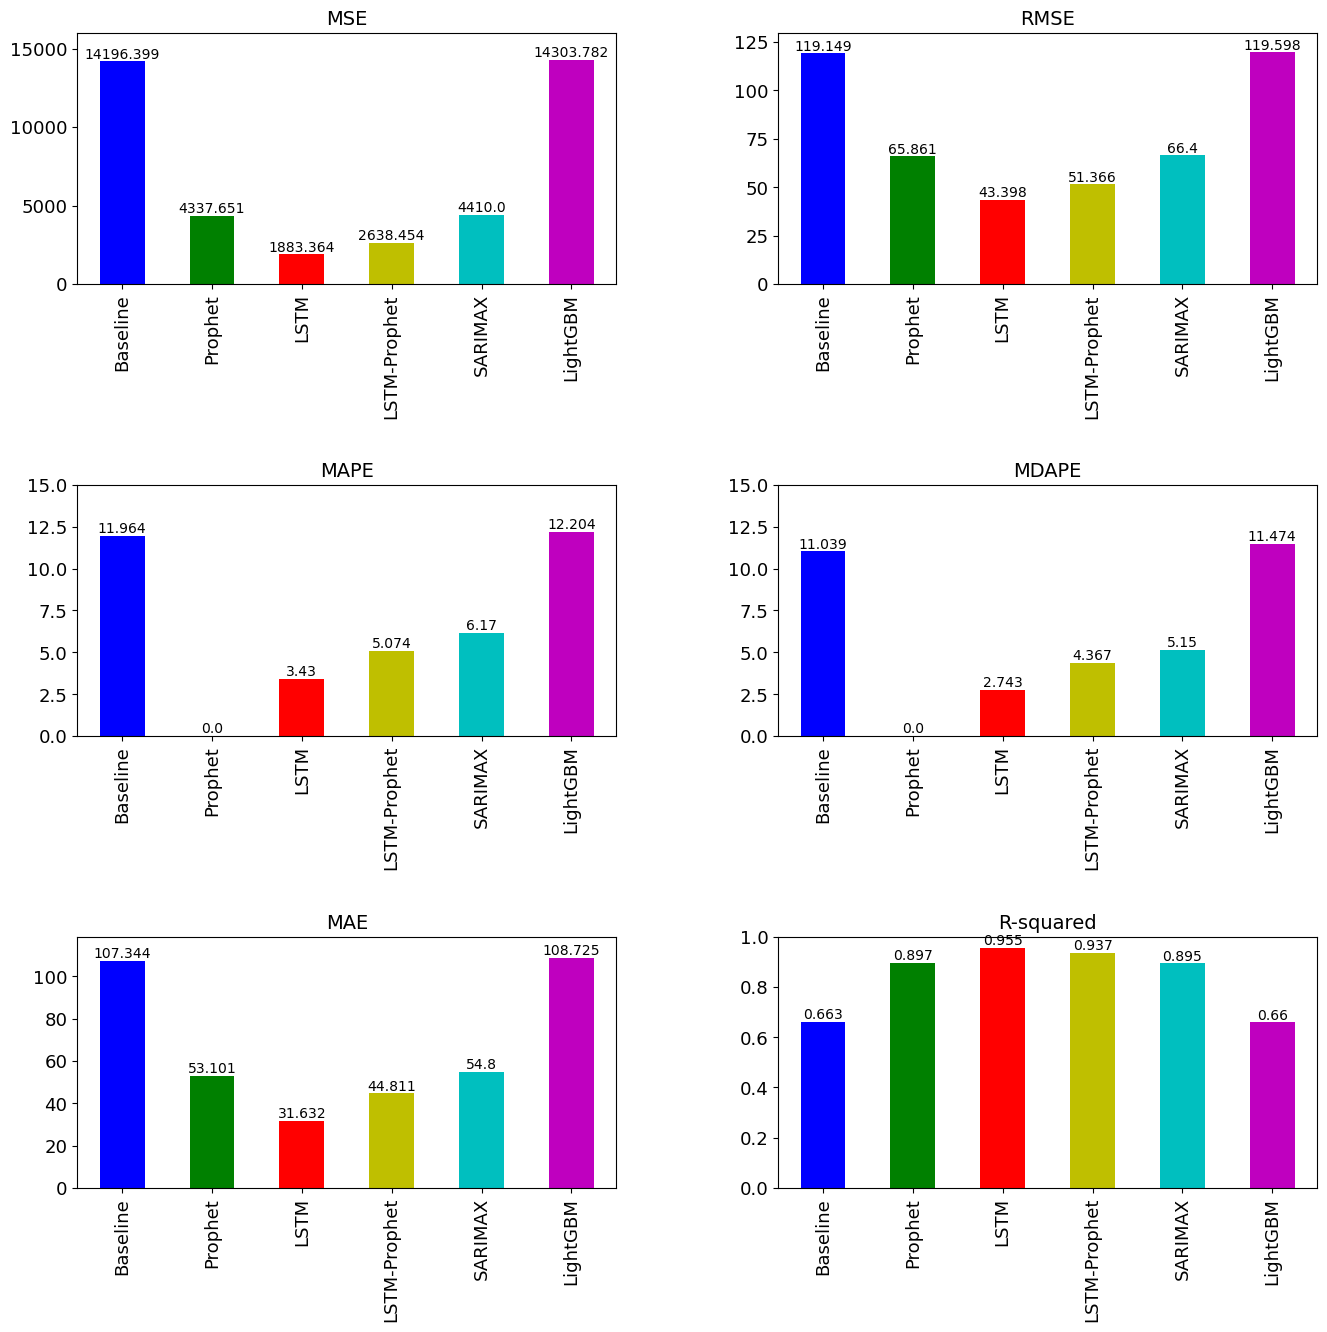

In [24]:
df = models_evaluation_df.copy()

# Replace any NaN values with zero
df.fillna(0, inplace=True)

# Set the index to 'Model' for easier plotting
df.set_index('Model', inplace=True)

# Define the colors for the different models
colors = {'Baseline': 'b', 'Prophet': 'g', 'LSTM': 'r', 'SARIMAX': 'c', 'LightGBM': 'm', 'LSTM-Prophet': 'y'}

# Plot bar charts for the different metrics in two columns
fig, axs = plt.subplots(3, 2, figsize=(16, 15))
axs = axs.ravel()
for i, metric in enumerate(['MSE', 'RMSE', 'MAPE', 'MDAPE', 'MAE', 'R-squared']):
    bars = df[metric].plot(kind='bar', ax=axs[i], color=[colors.get(model, 'k') for model in df.index])
    axs[i].set_title(metric, fontsize=14)
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='both', which='major', labelsize=13)
    axs[i].set_xlabel('')  # Remove x-label
    
    # Set y-axis limit
    if metric == 'MSE':
        axs[i].set_ylim([0, 16000])  # Set y-axis limit for MSE
    elif metric == 'MSE':
        axs[i].set_ylim([0, 150])  # Set y-axis limit for RMSE
    elif metric == 'R-squared':
        axs[i].set_ylim([0, 1])  # Set y-axis limit for R-squared
    elif metric == 'MAPE':
        axs[i].set_ylim([0, 15])  # Set y-axis limit for MAPE
    elif metric == 'MDAPE':
        axs[i].set_ylim([0, 15])  # Set y-axis limit for MDAPE
        
    else:
        axs[i].set_ylim([0, df[metric].max() + 10])  # Set y-axis limit for other metrics
    
    # Add values on the bars
    for bar in bars.patches:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, yval + .00005, round(yval, 3), ha='center', va='bottom')

# Increase space between the plots
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.show()

## 2. Comparison of Predicted Demand

In [49]:
models_predictions_df = pd.concat([baseline_predictions_df[['DATE', 'NG_DEMAND', 'Predicted_NG_DEMAND']], 
                                   prophet_predictions_df[['Predicted_NG_DEMAND']], 
                                   lstm_predictions_df[['Predicted_NG_DEMAND']], 
                                   hybrid_predictions_df[['Predicted_NG_DEMAND']], 
                                   sarimax_predictions_df[['Predicted_NG_DEMAND']], 
                                   lightgbm_predictions_df[['Predicted_NG_DEMAND']]], 
                                  axis=1)

models_predictions_df.columns = ['DATE', 'NG_DEMAND', 'Baseline', 'Prophet', 'LSTM', 'LSTM-Prophet', 'SARIMAX', 'LightGBM']
(models_predictions_df)

,DATE,NG_DEMAND,Baseline,Prophet,LSTM,LSTM-Prophet,SARIMAX,LightGBM
0,2022-05-01,894,781.657240,843.235901,893.61597,820.883303,898.334447,743.539982
1,2022-05-02,826,748.991212,822.467927,831.37756,772.038173,844.009205,714.426287
2,2022-05-03,818,733.653709,795.454454,821.90250,754.096731,826.412084,706.489290
3,2022-05-04,782,679.871677,759.290193,791.35140,715.880441,844.158550,652.244757
4,2022-05-05,737,603.493364,696.449118,748.77330,660.534089,752.060869,659.875452
...,...,...,...,...,...,...,...,...
544,2023-10-27,1066,1007.483542,1199.852283,1078.61020,1011.565990,1072.562150,1017.915353
545,2023-10-28,1058,1034.171223,1221.488383,1074.39780,1017.184168,1079.408825,1041.052761
546,2023-10-29,1062,997.379792,1189.455045,1071.35520,1004.188435,1068.147420,994.454520
547,2023-10-30,1104,1037.494016,1248.153253,NaN,1052.492601,1105.819448,986.982618


In [50]:
models_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          549 non-null    object 
 1   NG_DEMAND     549 non-null    int64  
 2   Baseline      549 non-null    float64
 3   Prophet       549 non-null    float64
 4   LSTM          547 non-null    float64
 5   LSTM-Prophet  548 non-null    float64
 6   SARIMAX       549 non-null    float64
 7   LightGBM      549 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 34.4+ KB


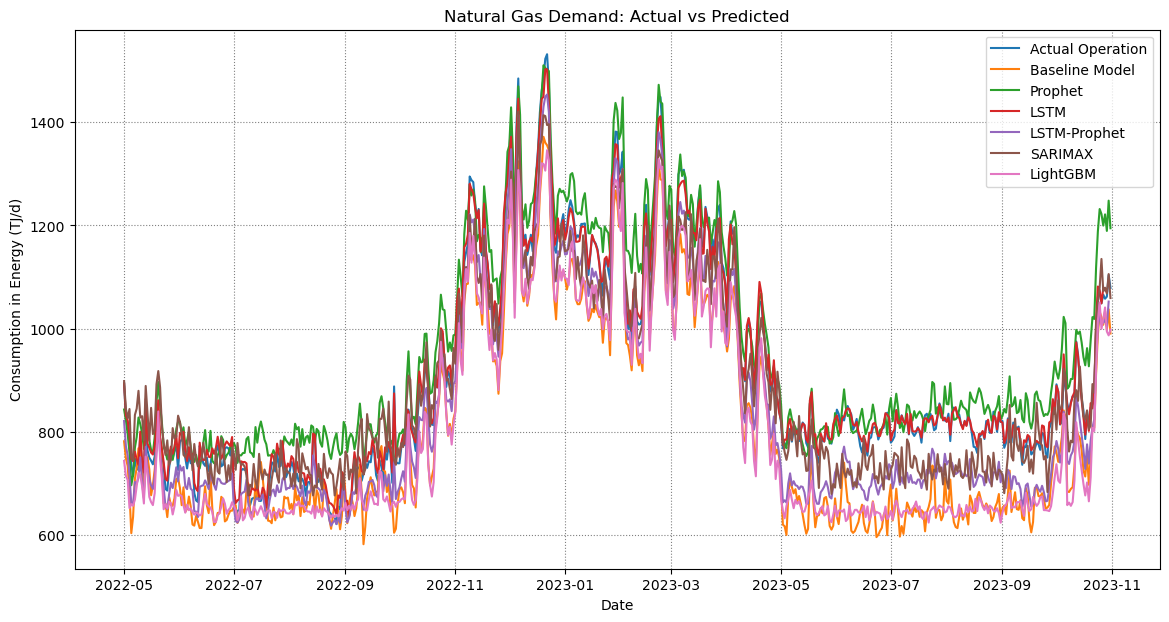

In [53]:
models_predictions_df['DATE'] = pd.to_datetime(models_predictions_df['DATE'])

# Plot the actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(models_predictions_df['DATE'], models_predictions_df['NG_DEMAND'], label='Actual Operation')
plt.plot(models_predictions_df['DATE'], models_predictions_df['Baseline'], label='Baseline Model')
plt.plot(models_predictions_df['DATE'], models_predictions_df['Prophet'], label='Prophet')
plt.plot(models_predictions_df['DATE'], models_predictions_df['LSTM'], label='LSTM')
plt.plot(models_predictions_df['DATE'], models_predictions_df['LSTM-Prophet'], label='LSTM-Prophet')
plt.plot(models_predictions_df['DATE'], models_predictions_df['SARIMAX'], label='SARIMAX')
plt.plot(models_predictions_df['DATE'], models_predictions_df['LightGBM'], label='LightGBM')

plt.title('Natural Gas Demand: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Consumption in Energy (TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.legend()
plt.show()

# Conclusion

- Baseline Model: This model has the highest Mean Squared Error (MSE) of 14196.40 and Root Mean Squared Error (RMSE) of 119.15, indicating that the predictions are, on average, quite far from the actual values. The Mean Absolute Percentage Error (MAPE) and Mean Directional Absolute Percentage Error (MDAPE) are 11.96% and 11.04% respectively, suggesting that the predictions are off by about 12% in both magnitude and direction. The R-squared value is 0.66, which means that about 66% of the variance in the target variable can be explained by the model.
- 
Prophet Model: This model significantly improves upon the baseline, with a lower MSE of 4337.65 and RMSE of 65.86. The MAPE and MDAPE values are not available (NaN), so we can’t comment on the percentage errors. The R-squared value is 0.90, indicating that the model explains 90% of the variance in the target variabl
- 

LSTM Model: This model performs even better, with the lowest MSE of 1883.36 and RMSE of 43.40 among all models. The MAPE and MDAPE are 3.43% and 2.74% respectively, indicating very accurate predictions both in terms of magnitude and direction. The R-squared value is the highest at 0.96, suggesting that the model explains 96% of the variance in the target varia
- e.

LSTM-Prophet Hybrid Model: This model has an MSE of 2638.45 and RMSE of 51.37, which are higher than the LSTM model but lower than the Prophet and Baseline models. The MAPE and MDAPE are 5.07% and 4.37% respectively. The R-squared value is 0- .94.

SARIMAX Model: This model has an MSE of 4410.00 and RMSE of 66.40, similar to the Prophet model. The MAPE and MDAPE are 6.17% and 5.15% respectively. The R-squared value is 0.90, same as the Prophet model.

Based on these metrics, the LSTM model appears to be the best model as it has the lowest error metrics (MSE, RMSE, MAPE, MDAPE) and the highest R-squared value. However, the choice of the best model can also depend on the specific requirements of the task, such as the trade-off between accuracy and computational efficiency. For example, if computation time or resources are a concern, a simpler model like Prophet or SARIMAX might be preferred despite their slightly higher error metrics. It’s also important to consider other factors such as the robustness of the model to changes in the data, ease of interpretation, and ease of implementation.